# CMPE 462 Machine Learning - TERM PROJECT
Hand written digit recognition from MNIST database.

## Description of the Dataset
<div style="text-align: justify; text-justify: inter-word; padding-top: 10px;">Our dataset consists of the original <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a> database except that its format has been changed to work better with numpy loader. Link of our data could be found <a href="https://www.kaggle.com/adnaan/mnistnpz/data">here</a>.The dataset has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. The MNIST database was constructed from NIST's Special Database 3 and Special Database 1 which contain binary images of handwritten digits. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.</div>

In [1]:
%matplotlib inline
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import time

Using TensorFlow backend.


In [30]:
f = np.load("data/mnist.npz")
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']
f.close()

img_rows, img_cols = x_train.shape[1:3]
batch_size = 100
num_classes = 10
epochs = 1
train_time = []
pred_time = []
accuracy = []

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.min() + (cm.max()-cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Metric Selection
Throughout the project, we used 'accuracy' as a way of ordering the performance of the classifiers.

## Baseline Model
We picked a baseline model as trivial as possible, which uniform randomly pick a class for any data point (image).

Test accuracy: 0.10440000000000005


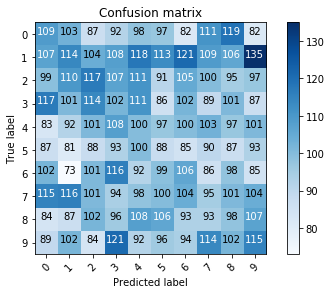

In [23]:
# TRIVIAL BASELINE MODEL
class BaselineModel:
    def __init__(self, num_of_classes):
        self.num_of_classes = num_of_classes
    
    def predict_classes(self, inputs):
        return np.random.randint(0, self.num_of_classes, len(inputs))

baseline_model = BaselineModel(num_classes)
pred_labels = baseline_model.predict_classes(x_test)
real_labels = np.argmax(y_test, axis=1)
label_err = pred_labels - real_labels
idx = np.where(label_err!=0)[0]
print('Test accuracy:', (1-len(idx)/len(label_err)))
confusion_mtx = confusion_matrix(real_labels, pred_labels)
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

# NAIVE BAYES MODELS

![](https://www.researchgate.net/profile/Jaya_Thomas3/publication/282282568/figure/fig1/AS:391497598947335@1470351709874/Example-of-naive-bayes-model-for-integrating-data-sources.png)

## Gaussian Naive Bayes Model

Training time =  0.4473433494567871
Predicting time =  0.9370293617248535
Test accuracy: 0.5558000000000001


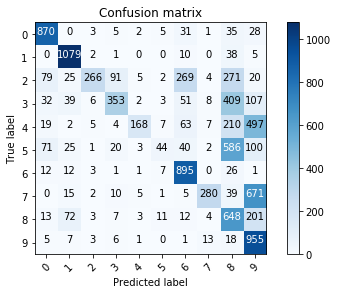

In [83]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb = GaussianNB()
train_label = np.argmax(y_train, axis=1)
'''
for i in range(5000, 60000, 5000):
    gaussian_nb.fit(x_train.reshape(60000, 784)[i:i+5000, :] , train_label[i:i+5000])
    pred_labels = gaussian_nb.predict(x_test.reshape(10000,784))
    label_err = pred_labels - real_labels
    idx = np.where(label_err!=0)[0]
    print('Batch size= ', i, ', Test accuracy:', (1-len(idx)/len(label_err)))
'''
start = time.time()
gaussian_nb.fit(x_train.reshape(60000, 784) , train_label)
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)

start = time.time()
pred_labels = gaussian_nb.predict(x_test.reshape(10000,784))
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

label_err = pred_labels - real_labels
idx = np.where(label_err!=0)[0]
print('Test accuracy:', (1-len(idx)/len(label_err)))
accuracy.append(1-len(idx)/len(label_err))
conf_matrix = confusion_matrix(real_labels, pred_labels)
plot_confusion_matrix(conf_matrix, classes = range(num_classes))

## Multinomial Naive Bayes Model

Training time =  0.2599983215332031
Predicting time =  0.04161834716796875
Test accuracy: 0.8357


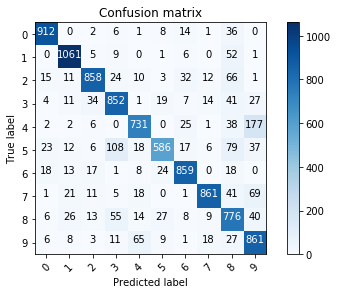

In [32]:
from sklearn.naive_bayes import MultinomialNB
multi_nb = MultinomialNB()
'''
for i in range(5000, 60000, 5000):
    multi_nb.fit(x_train.reshape(60000, 784)[0:i, :] , train_label[0:i])
    pred_labels = multi_nb.predict(x_test.reshape(10000,784))
    label_err = pred_labels - real_labels
    idx = np.where(label_err!=0)[0]
    print('Batch size= ', i, ', Test accuracy:', (1-len(idx)/len(label_err)))
'''
start = time.time()
multi_nb.fit(x_train.reshape(60000, 784) , train_label)
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)

start = time.time()
pred_labels = multi_nb.predict(x_test.reshape(10000, 784))
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

label_err = pred_labels - real_labels
idx = np.where(label_err!=0)[0]
print('Test accuracy:', (1-len(idx)/len(label_err)))
accuracy.append(1-len(idx)/len(label_err))
conf_matrix = confusion_matrix(real_labels, pred_labels)
plot_confusion_matrix(conf_matrix, classes = range(num_classes))

## Bernoulli Naive Bayes Model

Training time =  0.6050407886505127
Predicting time =  0.08920979499816895
Test accuracy: 0.8412999999999999


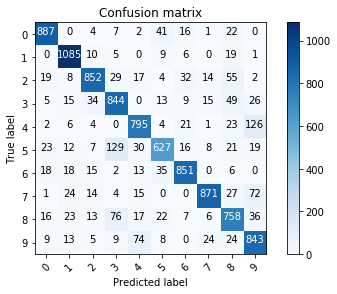

In [33]:
from sklearn.naive_bayes import BernoulliNB
bern_nb = BernoulliNB()
'''
for i in range(5000, 60000, 5000):
    bern_nb.fit(x_train.reshape(60000, 784)[0:i, :] , train_label[0:i])
    pred_labels = bern_nb.predict(x_test.reshape(10000,784))
    label_err = pred_labels - real_labels
    idx = np.where(label_err!=0)[0]
    print('Batch size= ', i, ', Test accuracy:', (1-len(idx)/len(label_err)))
'''
start = time.time()
bern_nb.fit(x_train.reshape(60000, 784) , train_label)
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)

start = time.time()
pred_labels = bern_nb.predict(x_test.reshape(10000,784))
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

label_err = pred_labels - real_labels
idx = np.where(label_err!=0)[0]
print('Test accuracy:', (1-len(idx)/len(label_err)))
accuracy.append(1-len(idx)/len(label_err))
conf_matrix = confusion_matrix(real_labels, pred_labels)
plot_confusion_matrix(conf_matrix, classes = range(num_classes))

## Linear Support Vector Machine (SVM) Model
![](https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png)

Training time =  110.071768283844
Predicting time =  0.06056690216064453
Test accuracy: 0.9185


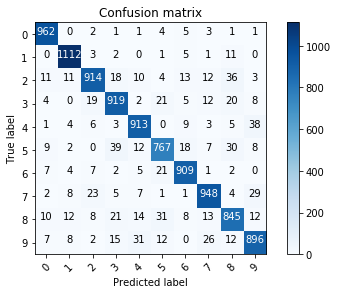

In [34]:
# BUILD SVM MODEL
from sklearn import svm, metrics

classifier = svm.LinearSVC()
start = time.time()
classifier.fit(x_train.reshape(60000, 784), train_label)
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)

## Run the classifier on test data
start = time.time()
pred = classifier.predict(x_test.reshape(10000, 784))
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

print ('Test accuracy:', metrics.accuracy_score(real_labels, pred))
accuracy.append(1-len(idx)/len(label_err))
confusion_mtx = confusion_matrix(real_labels, pred)
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

## K Nearest Neighbour (KNN) Model
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/419px-KnnClassification.svg.png)

Training time =  37.679160594940186
Predicting time =  3561.2855052948
Test accuracy: 0.9697


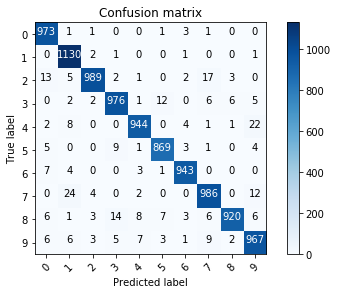

In [35]:
# BUILD K Nearest Neighbour MODEL
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=10, weights='uniform', p=3, n_jobs=-1)
real_labels = np.argmax(y_train, axis=1)
start = time.time()
knn_model.fit(x_train.reshape(x_train.shape[0], img_rows*img_cols), real_labels)
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)

# from sklearn.externals import joblib
# joblib.dump(knn_model, "MODELS/knn_model.dump", compress=3)
# knn_model = joblib.load("MODELS/knn_model.dump")
start = time.time()
pred_labels = knn_model.predict(x_test.reshape(x_test.shape[0], img_rows*img_cols))
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

# pred_labels.dump("MODELS/knn_predicted_labels.txt")
# pred_labels = np.load("MODELS/knn_predicted_labels.txt")
real_labels = np.argmax(y_test, axis=1)
label_err = pred_labels - real_labels
idx = np.where(label_err!=0)[0]
print('Test accuracy:', (1-len(idx)/len(label_err)))
accuracy.append(1-len(idx)/len(label_err))
confusion_mtx = confusion_matrix(real_labels, pred_labels)
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

## Multi Layer Perceptron (MLP) Classifier Model
![](https://www.researchgate.net/profile/Mouhammd_Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.jpg)

Training time =  57.453218936920166
Predicting time =  0.07006955146789551
Test accuracy: 0.9766


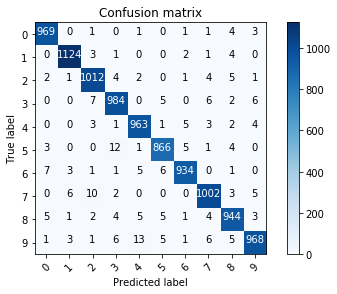

In [36]:
# BUILD MLP CLASSIFIER MODEL
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
start = time.time()
classifier.fit(x_train.reshape(60000, 784), train_label)
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)

## Run the classifier on test data
start = time.time()
pred = classifier.predict(x_test.reshape(10000, 784))
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

print ('Test accuracy:', metrics.accuracy_score(real_labels, pred))
accuracy.append(1-len(idx)/len(label_err))
confusion_mtx = confusion_matrix(real_labels, pred)
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

## Convolutional Neural Network (CNN) Model
![](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 249s 4ms/step - loss: 0.1924 - acc: 0.9425 - val_loss: 0.0470 - val_acc: 0.9845
Training time =  254.50048732757568
Predicting time =  13.016660451889038
Test accuracy: 0.9845


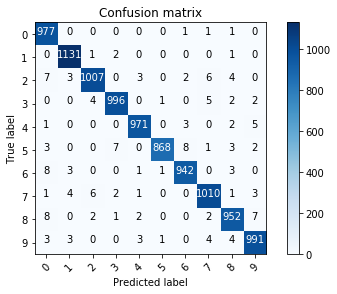

In [39]:
# BUILD CNN MODEL
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=keras.initializers.VarianceScaling()))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=keras.initializers.VarianceScaling()))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu',
                    kernel_initializer=keras.initializers.VarianceScaling()))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=keras.initializers.VarianceScaling()))

cnn_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
start = time.time()
cnn_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
end = time.time()
print('Training time = ', end-start)
train_time.append(end-start)
# cnn_model.save('MODELS/CNN_model.h5')
# from keras.models import load_model
# cnn_model = load_model('MODELS/CNN_model.h5')

start = time.time()
pred = cnn_model.predict(x_test)
end = time.time()
print('Predicting time = ', end-start)
pred_time.append(end-start)

pred_labels = np.argmax(pred, axis=1)
real_labels = np.argmax(y_test, axis=1)
label_err = pred_labels - real_labels
idx = np.where(label_err!=0)[0]
worst_err = np.abs(pred-y_test)[idx, real_labels[idx].astype(int)]
worst_idx = np.flip(np.argsort(worst_err), axis=0)

print('Test accuracy:', (1-len(idx)/len(label_err)))
accuracy.append(1-len(idx)/len(label_err))
confusion_mtx = confusion_matrix(real_labels, pred_labels)
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

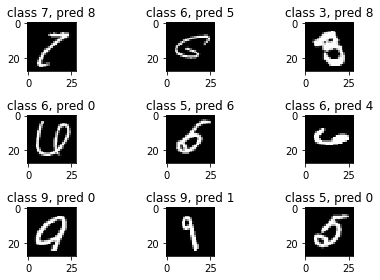

In [10]:
# A few of the wrong predicted digits
for i in range(min(9, len(worst_err))):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx[worst_idx[i]]].reshape(img_rows, img_cols), cmap='gray', interpolation='none')
    plt.title("class {}, pred {}".format(real_labels[idx[worst_idx[i]]], pred_labels[idx[worst_idx[i]]]))
plt.tight_layout()

A simple plot to see the time consumption (both in training and prediction parts) vs accuracy of the models. (Executed on the computer having an Intel i7-4712MQ (2.30 GHz*8) CPU )

In [40]:
print(train_time)

[0.4411797523498535, 0.2599983215332031, 0.6050407886505127, 110.071768283844, 37.679160594940186, 57.453218936920166, 254.50048732757568]


In [41]:
print(pred_time)

[0.9142899513244629, 0.04161834716796875, 0.08920979499816895, 0.06056690216064453, 3561.2855052948, 0.07006955146789551, 13.016660451889038]


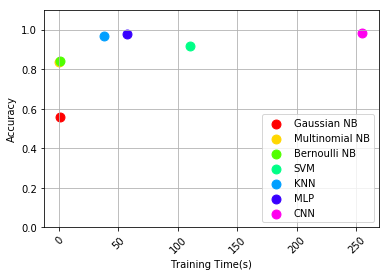

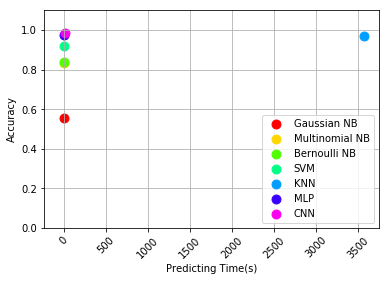

In [14]:
model_labels = ['Gaussian NB', 'Multinomial NB', 'Bernoulli NB', 'SVM', 'KNN', 'MLP', 'CNN']
cmap = plt.cm.get_cmap('hsv', len(accuracy)+1)

fig, ax = plt.subplots()
for i, (X, Y) in enumerate(zip(train_time, accuracy)):
    ax.scatter(X, Y, c=cmap(i), label=model_labels[i], s=80)
plt.ylim(0,1.1)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Training Time(s)')
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
for i, (X, Y) in enumerate(zip(pred_time, accuracy)):
    ax.scatter(X, Y, c=cmap(i), label=model_labels[i], s=80)
plt.ylim(0,1.1)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Predicting Time(s)')
ax.legend()
ax.grid(True)
plt.show()